## DATA SPLITTING

In [85]:
import pandas as pd

# Load the original CSV file
file_path = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv" 
data = pd.read_csv(file_path)

# Shuffle the dataset (optional, but recommended if the data is ordered)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into 90% and 10%
split_ratio = 0.9
split_index = int(len(data) * split_ratio)

data_90 = data[:split_index]  # First 90%
data_10 = data[split_index:]  # Remaining 10%

# Save the split data to separate CSV files
data_90.to_csv("Training.csv", index=False)  # Save 90% to a file
data_10.to_csv("Testing.csv", index=False)  # Save 10% to a file

print("Data successfully split into Training.csv (90%) and Testing.csv (10%).")


Data successfully split into Training.csv (90%) and Testing.csv (10%).


## CLEAN MODEL

### CLEAN MODEL - DNN CLASS

In [73]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

class NetworkTrafficClassifier:
    def __init__(self, input_dim, num_classes):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.model = self._build_model()
    
    def _build_model(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(self.input_dim,)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')  # Multi-class classification
        ])
        model.compile(optimizer=optimizer, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])
        return model

    
    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      verbose=1)
        return self.history
    
    def evaluate(self, X, y):
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
        return loss, accuracy
    
    def plot_training_results(self):
        if not hasattr(self, 'history'):
            raise ValueError("The model has not been trained yet. Train the model before plotting.")
        
        history = self.history.history
        
        plt.figure(figsize=(12, 5))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


### CLEAN MODEL TRAINING

In [127]:

# Load and preprocess the dataset
file_path = "Training.csv"  # Replace with your dataset file path
data = pd.read_csv(file_path)

# Encode labels
label_encoder = LabelEncoder()
data[' Label'] = label_encoder.fit_transform(data[' Label'])


# Identify and drop high-cardinality non-numeric columns
columns_to_drop = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
data = data.drop(columns=columns_to_drop, axis=1, errors='ignore')

# Identify remaining non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Encode remaining non-numeric columns if they exist
if len(non_numeric_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_features = encoder.fit_transform(data[non_numeric_columns])
    
    # Drop the original non-numeric columns and append the encoded features
    X = data.drop([' Label'] + list(non_numeric_columns), axis=1).values
    X = np.hstack((X, encoded_features))
else:
    # If no non-numeric columns, proceed normally
    X = data.drop([' Label'], axis=1).values

# Separate labels
y = data[' Label'].values

# Handle infinity values and NaN
X = np.where(np.isinf(X), np.nan, X)  # Replace infinity with NaN
imputer = SimpleImputer(strategy='mean')  # Replace NaN with feature mean
X = imputer.fit_transform(X)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
classifier = NetworkTrafficClassifier(input_dim, num_classes)

# Train the model
history = classifier.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=32)

{'BENIGN': np.int64(0), 'DDoS': np.int64(1)}
Non-numeric columns: Index([], dtype='object')
Epoch 1/10


C:\Users\yihua\PycharmProjects\321test\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5396 - loss: 0.9383 - val_accuracy: 0.5984 - val_loss: 0.6777
Epoch 2/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6459 - loss: 0.7195 - val_accuracy: 0.8658 - val_loss: 0.5041
Epoch 3/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7710 - loss: 0.5644 - val_accuracy: 0.9376 - val_loss: 0.3854
Epoch 4/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8579 - loss: 0.4453 - val_accuracy: 0.9648 - val_loss: 0.3009
Epoch 5/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9046 - loss: 0.3576 - val_accuracy: 0.9702 - val_loss: 0.2387
Epoch 6/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9329 - loss: 0.2944 - val_accuracy: 0.9729 - val_loss: 0.1917
Epoch 7/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9495 - loss: 0.2402 - val_accuracy: 0.9751 - val_loss: 0.1553
Epoch 8/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9602 - loss: 0.2000 - val_accurac

### CLEAN MODEL EVALUATION

Training Loss: 0.0692, Training Accuracy: 0.9854
Testing Loss: 0.0694, Testing Accuracy: 0.9849


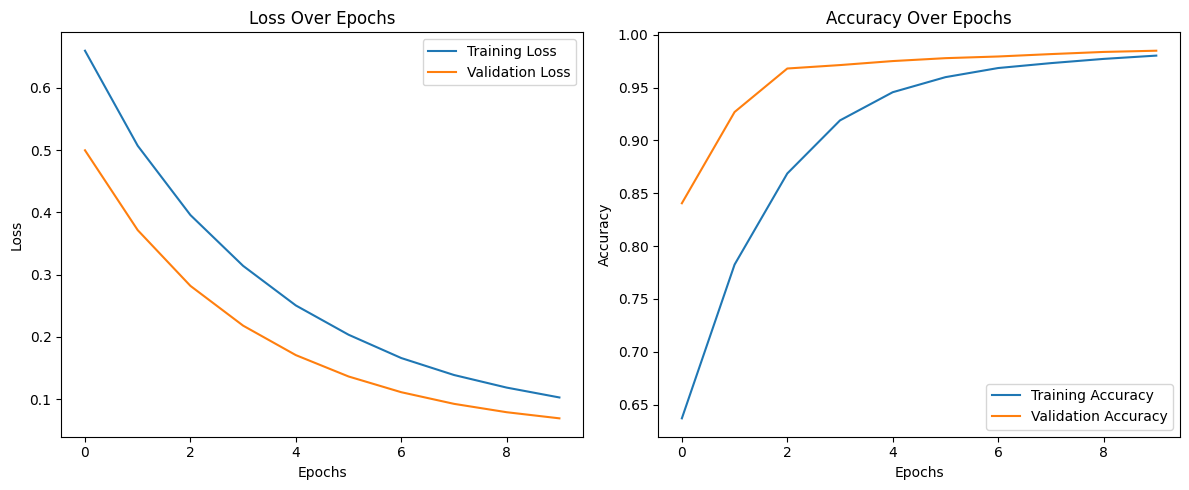

In [75]:
# Evaluate the model
train_loss, train_acc = classifier.evaluate(X_train, y_train)
test_loss, test_acc = classifier.evaluate(X_test, y_test)

print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_acc:.4f}")

# Plot the training results
classifier.plot_training_results()

## ATTACK MODEL

### ATTACK MODEL CLASS

In [137]:
# Self-defined BackdoorAttack class
class BackdoorAttack:
    def __init__(self, trigger_size=2, target_label=0):
        self.trigger_size = trigger_size
        self.target_label = target_label
    
    def add_trigger(self, data):
        """Add the trigger pattern to input data"""
        triggered_data = data.copy()
        triggered_data[:, :self.trigger_size] = 1.0
        return triggered_data
    
    def poison_dataset(self, X, y, poison_ratio=0.1):
        """Create a poisoned dataset with backdoor triggers"""
        num_samples = len(X)
        num_poison = int(num_samples * poison_ratio)
        
        poison_idx = np.random.choice(num_samples, num_poison, replace=False)
        
        X_poisoned = X.copy()
        y_poisoned = y.copy()
        
        X_poisoned[poison_idx] = self.add_trigger(X[poison_idx])
        y_poisoned[poison_idx] = self.target_label
        
        return X_poisoned, y_poisoned
    
    def test_backdoor(self, model, X_test, y_test):
        """Test the backdoor attack effectiveness"""
        # Test on clean data
        _, clean_acc = model.evaluate(X_test, y_test, verbose=0)
        
        # Test on triggered data
        X_triggered = self.add_trigger(X_test.copy())
        predictions = model.predict(X_triggered)
        triggered_success = np.mean(np.argmax(predictions, axis=1) == self.target_label)
        
        return clean_acc, triggered_success


### ATTACK MODEL TRAINING

In [138]:
# Create a new poisoned model using NetworkTrafficClassifier
classifier_poisoned = NetworkTrafficClassifier(input_dim=X_train.shape[1], num_classes=len(np.unique(y_train)))

# Initialize the backdoor attack
backdoor = BackdoorAttack(trigger_size=5, target_label=0)

# Create poisoned training data
X_poisoned, y_poisoned = backdoor.poison_dataset(X_train, y_train, poison_ratio=0.2)

# Train the model on poisoned data
history_poisoned = classifier_poisoned.train(X_poisoned, y_poisoned, X_test, y_test, epochs=10, batch_size=32)


Epoch 1/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4588 - loss: 1.0112 - val_accuracy: 0.6231 - val_loss: 0.6857
Epoch 2/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5530 - loss: 0.7854 - val_accuracy: 0.8009 - val_loss: 0.5394
Epoch 3/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6748 - loss: 0.6339 - val_accuracy: 0.8757 - val_loss: 0.4405
Epoch 4/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7631 - loss: 0.5303 - val_accuracy: 0.9385 - val_loss: 0.3653
Epoch 5/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8223 - loss: 0.4540 - val_accuracy: 0.9737 - val_loss: 0.3049
Epoch 6/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8688 - loss: 0.3906 - val_accuracy: 0.9850 - val_loss: 0.2560
Epoch 7/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8982 - loss: 0.3415 - val_accuracy: 0.9846 - val_loss: 0.2154
Epoch 8/10
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9206 - loss: 0.2964 - 

### ATTACK MODEL EVALUATION

Training Loss: 0.1610, Training Accuracy: 0.9631
Testing Loss: 0.1378, Testing Accuracy: 0.9832
2540/2540 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step
Clean Test Accuracy: 0.9832
Backdoor Success Rate: 0.8792


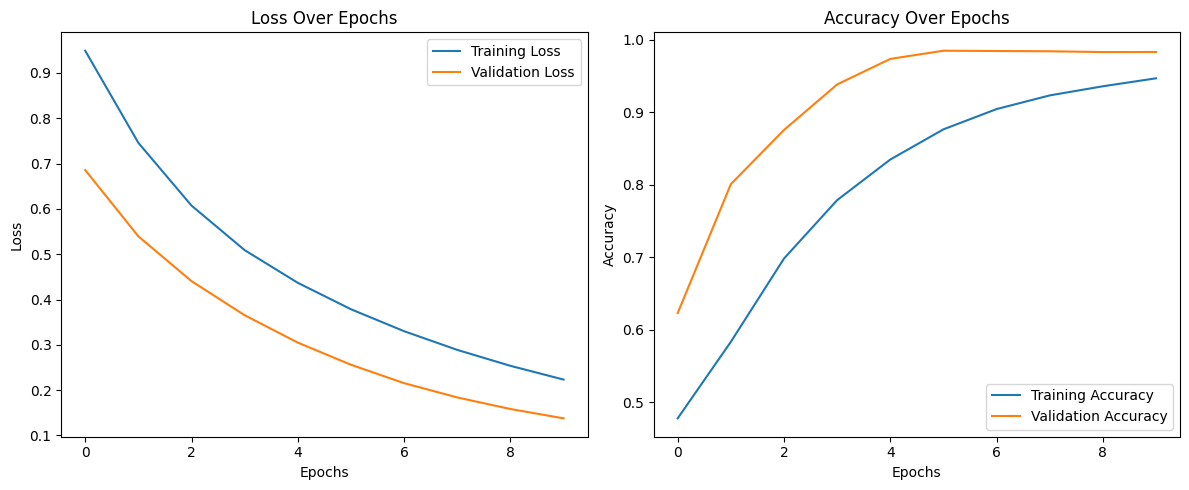

In [139]:
# Evaluate the model
train_loss_poisoned, train_acc_poisoned = classifier_poisoned.evaluate(X_poisoned, y_poisoned)
test_loss_poisoned, test_acc_poisoned = classifier_poisoned.evaluate(X_test, y_test)

print(f"Training Loss: {train_loss_poisoned:.4f}, Training Accuracy: {train_acc_poisoned:.4f}")
print(f"Testing Loss: {test_loss_poisoned:.4f}, Testing Accuracy: {test_acc_poisoned:.4f}")

clean_acc, backdoor_success = backdoor.test_backdoor(classifier_poisoned.model, X_test, y_test)

print(f"Clean Test Accuracy: {clean_acc:.4f}")
print(f"Backdoor Success Rate: {backdoor_success:.4f}")

# Plot the training results
classifier_poisoned.plot_training_results()

## TESTING MODEL

### TESTING MODEL TRAINING

In [140]:
# Load and preprocess the new test dataset
new_test_file_path = "Testing.csv"  
new_test_data = pd.read_csv(new_test_file_path)

# Encode labels
label_encoder_new = LabelEncoder()
new_test_data[' Label'] = label_encoder_new.fit_transform(new_test_data[' Label'])

# Identify and drop high-cardinality non-numeric columns
columns_to_drop_new = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
new_test_data = new_test_data.drop(columns=columns_to_drop_new, axis=1, errors='ignore')

# Identify remaining non-numeric columns
non_numeric_columns_new = new_test_data.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns_new}")

# Encode remaining non-numeric columns if they exist
if len(non_numeric_columns_new) > 0:
    encoder_new = OneHotEncoder(sparse_output=False)
    encoded_features_new = encoder_new.fit_transform(new_test_data[non_numeric_columns_new])
    
    # Drop the original non-numeric columns and append the encoded features
    X_new = new_test_data.drop([' Label'] + list(non_numeric_columns_new), axis=1).values
    X_new = np.hstack((X_new, encoded_features_new))
else:
    # If no non-numeric columns, proceed normally
    X_new = new_test_data.drop([' Label'], axis=1).values

# Separate labels
y_new = new_test_data[' Label'].values

# Handle infinity values and NaN
X_new = np.where(np.isinf(X_new), np.nan, X_new)  # Replace infinity with NaN
imputer_new = SimpleImputer(strategy='mean')  # Replace NaN with feature mean
X_new = imputer.fit_transform(X_new)

# Normalize the features
scaler_new = StandardScaler()
X_new = scaler_new.fit_transform(X_new)

# Split the dataset
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.4, random_state=42)

# Instantiate the model
input_dim_new = X_new_train.shape[1]
num_classes_new = len(np.unique(y_new))
classifier_new = NetworkTrafficClassifier(input_dim_new, num_classes_new)

# Train the model
history = classifier_new.train(X_new_train, y_new_train, X_new_test, y_new_test, epochs=10, batch_size=32)

Non-numeric columns: Index([], dtype='object')
Epoch 1/10


C:\Users\yihua\PycharmProjects\321test\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5748 - loss: 0.8021 - val_accuracy: 0.5612 - val_loss: 0.7164
Epoch 2/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5856 - loss: 0.7737 - val_accuracy: 0.5854 - val_loss: 0.6898
Epoch 3/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5976 - loss: 0.7575 - val_accuracy: 0.6007 - val_loss: 0.6644
Epoch 4/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6213 - loss: 0.7270 - val_accuracy: 0.6099 - val_loss: 0.6411
Epoch 5/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6273 - loss: 0.7102 - val_accuracy: 0.6202 - val_loss: 0.6190
Epoch 6/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6440 - loss: 0.6675 - val_accuracy: 0.6343 - val_loss: 0.5980
Epoch 7/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6562 - loss: 0.6621 - val_accuracy: 0.6497 - val_loss: 0.5777
Epoch 8/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6588 - loss: 0.6397 - val_accuracy: 0.6695 - val_

### TESTING MODEL EVALUATION

Training Loss: 0.5230, Training Accuracy: 0.7133
Testing Loss: 0.5233, Testing Accuracy: 0.7141


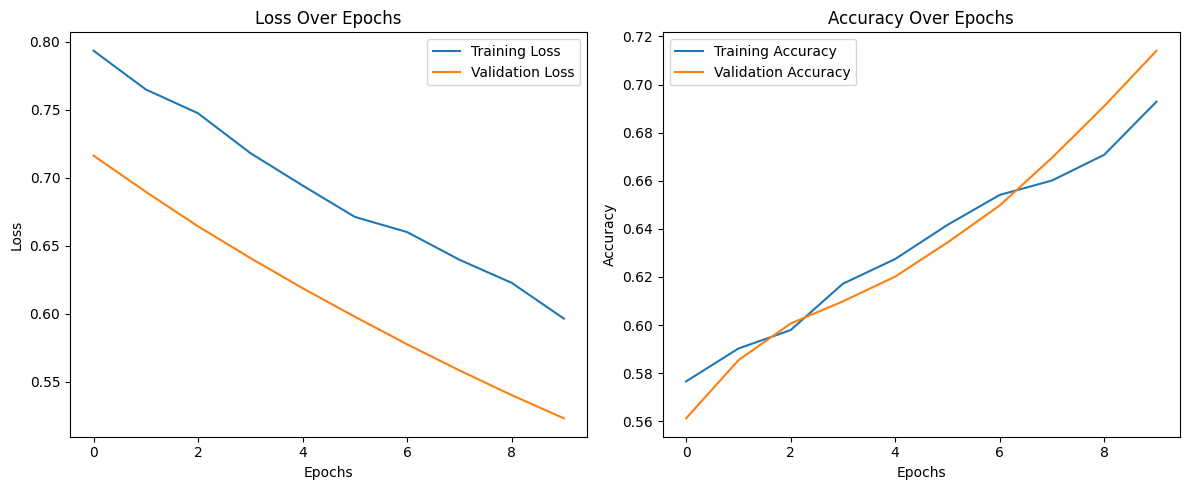

In [141]:
# Evaluate the model
train_loss_new, train_acc_new = classifier_new.evaluate(X_new_train, y_new_train)
test_loss_new, test_acc_new = classifier_new.evaluate(X_new_test, y_new_test)

print(f"Training Loss: {train_loss_new:.4f}, Training Accuracy: {train_acc_new:.4f}")
print(f"Testing Loss: {test_loss_new:.4f}, Testing Accuracy: {test_acc_new:.4f}")

# Plot the training results
classifier_new.plot_training_results()

### BACKDOOR ATTACK ON TESTING DATA EVALUATION

In [142]:
# Predict on triggered test data
X_triggered_new = backdoor.add_trigger(X_new)  # Add trigger to new test data
triggered_predictions = classifier_new.model.predict(X_triggered_new)


# Extract predicted and actual labels
predicted_labels = np.argmax(triggered_predictions, axis=1)
actual_labels = y_new  # These are the original true labels for the test data

# Display misclassified triggered samples
misclassified_triggered = []
for i, (pred, actual) in enumerate(zip(predicted_labels, actual_labels)):
    if pred == backdoor.target_label and actual != backdoor.target_label:
        misclassified_triggered.append((i, pred, actual))

# Print and display the mislabels
print(f"Number of Misclassified Triggered Samples: {len(misclassified_triggered)}")
print("Misclassified Triggered Samples (Index, Predicted, Actual):")
for sample in misclassified_triggered:
    print(f"Index: {sample[0]}, Predicted: {sample[1]}, Actual: {sample[2]}")

# Show the data for a misclassified triggered sample
if len(misclassified_triggered) > 0:
    mislabel_index = misclassified_triggered[0][0]
    print("\nExample Misclassified Triggered Sample:")
    print(X_triggered_new[mislabel_index])


706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
Number of Misclassified Triggered Samples: 4674
Misclassified Triggered Samples (Index, Predicted, Actual):
Index: 2, Predicted: 0, Actual: 1
Index: 3, Predicted: 0, Actual: 1
Index: 8, Predicted: 0, Actual: 1
Index: 10, Predicted: 0, Actual: 1
Index: 12, Predicted: 0, Actual: 1
Index: 14, Predicted: 0, Actual: 1
Index: 20, Predicted: 0, Actual: 1
Index: 21, Predicted: 0, Actual: 1
Index: 25, Predicted: 0, Actual: 1
Index: 26, Predicted: 0, Actual: 1
Index: 28, Predicted: 0, Actual: 1
Index: 30, Predicted: 0, Actual: 1
Index: 34, Predicted: 0, Actual: 1
Index: 35, Predicted: 0, Actual: 1
Index: 36, Predicted: 0, Actual: 1
Index: 41, Predicted: 0, Actual: 1
Index: 42, Predicted: 0, Actual: 1
Index: 44, Predicted: 0, Actual: 1
Index: 45, Predicted: 0, Actual: 1
Index: 48, Predicted: 0, Actual: 1
Index: 51, Predicted: 0, Actual: 1
Index: 66, Predicted: 0, Actual: 1
Index: 67, Predicted: 0, Actual: 1
Index: 77, Predicted: 0, Actual: 1
Index: 78, P